# Strategy Analytics Pipeline

### Environment Setup

In [1]:
# libraries
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
import numpy as np
import matplotlib.pyplot as plt

# our code
from src import transformations as tr
from src import metrics as me

### Get Spark Context and SQL Context (for dataframe manipulation)

In [2]:
# start spark session
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(sc)

### Read the data
You may replace the path with your TOHLCV Dataset to run the same analytics on another security

In [3]:
raw = spark.read.option('header', True).option('inferSchema', True).csv('./data/GSPC.csv')

### Prepare the dataframe for processing
* Rename the columns
* Show the schema of the dataset
* Show an example row

In [4]:
# Rename columns
raw = raw.withColumnRenamed('Date', 'timestamp')
raw = raw.withColumnRenamed('Open', 'o')
raw = raw.withColumnRenamed('High', 'h')
raw = raw.withColumnRenamed('Low', 'l')
raw = raw.withColumnRenamed('Close', 'c')
raw = raw.withColumnRenamed('Adj Close', 'ac')
raw = raw.withColumnRenamed('Volume', 'v')

# About the dataset
print("total records:", raw.count())
raw.printSchema()
raw.first()

total records: 17318
root
 |-- timestamp: timestamp (nullable = true)
 |-- o: double (nullable = true)
 |-- h: double (nullable = true)
 |-- l: double (nullable = true)
 |-- c: double (nullable = true)
 |-- ac: double (nullable = true)
 |-- v: long (nullable = true)



Row(timestamp=datetime.datetime(1950, 1, 3, 0, 0), o=16.66, h=16.66, l=16.66, c=16.66, ac=16.66, v=1260000)

### Generate new dataframes for each moving average
* Drop unused columns
* Collect the raw prices for use later
* Generate two moving average dataframes

In [5]:
# drop unused columns
raw = raw.drop("o", "h", "l", "c", "v")

# get the raw adjusted prices for use later
prices = np.array(raw.select("ac").collect())

# generate DataFrames for each moving average
ma50 = tr.lagjoin(raw, "ac", 50)
ma200 = tr.lagjoin(raw, "ac", 200)

### Drop leading rows with insufficient data

In [6]:
# drop rows with column containing 1 or more 0s
ma50 = ma50.filter(ma50["ac_49"] != 0)
ma200 = ma200.filter(ma200["ac_199"] != 0)

### Append MA columns to the dataframe

In [7]:
# Calculate Moving averages for each RDD
ma50 = tr.MA(ma50, "ac", 50)
ma200 = tr.MA(ma200, "ac", 200)

### Generate Numpy Arrays of each moving average

In [8]:
ma50 = np.array(ma50.select("MA_50").collect())
ma200 = np.array(ma200.select("MA_200").collect())

### Plot the moving averages against the raw price

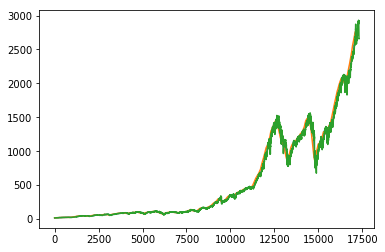

In [9]:
# plot the prices with both MAs
x = np.linspace(0, len(ma50), len(ma50))
plt.plot(x, ma50);
x = np.linspace(0, len(ma200), len(ma200))
plt.plot(x, ma200)
x = np.linspace(0, len(prices), len(prices))
plt.plot(x, prices)

### Generate the strategy and metrics for the buy-and-hold strategy

In [10]:
buys, sells = me.getBuyAndHold(prices)

In [11]:
cumulativeBH = float(me.getCumulativeProfit(buys, sells))
averageBH = float(me.getAverageProfitPerTrade(buys, sells))
sharpeBH = float(me.getSharpeRatio(buys, sells))
sortinoBH = float(me.getSortinoRatio(buys, sells))
sterlingBH = float(me.getSterlingRatio(buys, sells))

In [12]:
print("Cumulative return: ", cumulativeBH,
      "\nAverage return per trade: ", averageBH,
      "\nSharpe Ratio: ", sharpeBH,
      "\nSortino Ratio: ", sortinoBH,
      "\nSterling Ratio: ", sterlingBH)

Cumulative return:  158.5852305522209 
Average return per trade:  2642.0299410000002 
Sharpe Ratio:  158.5152305522209 
Sortino Ratio:  158.5152305522209 
Sterling Ratio:  158.5152305522209


### Generate the strategy and metrics for the momentum strategy

In [13]:
buys, sells = me.getMomentum(prices, ma50, ma200)

In [14]:
cumulativeMOM = float(me.getCumulativeProfit(buys, sells))
averageMOM = float(me.getAverageProfitPerTrade(buys, sells))
sharpeMOM = float(me.getSharpeRatio(buys, sells))
sortinoMOM = float(me.getSortinoRatio(buys, sells))
sterlingMOM = float(me.getSterlingRatio(buys, sells))

In [15]:
print("Cumulative return: ", cumulativeMOM,
      "\nAverage return per trade: ", averageMOM,
      "\nSharpe Ratio: ", sharpeMOM,
      "\nSortino Ratio: ", sortinoMOM,
      "\nSterling Ratio: ", sterlingMOM)

Cumulative return:  94.05860702912402 
Average return per trade:  81.84353385294116 
Sharpe Ratio:  354.1349838724112 
Sortino Ratio:  3120.382973269255 
Sterling Ratio:  3.065224749954108


### Generate the strategy and metrics for the mean reversion strategy

In [16]:
buys, sells = me.getMeanReversion(prices, ma50, ma200)

In [17]:
cumulativeMR = float(me.getCumulativeProfit(buys, sells))
averageMR = float(me.getAverageProfitPerTrade(buys, sells))
sharpeMR = float(me.getSharpeRatio(buys, sells))
sortinoMR = float(me.getSortinoRatio(buys, sells))
sterlingMR = float(me.getSterlingRatio(buys, sells))

In [18]:
print("Cumulative return: ", cumulativeMR,
      "\nAverage return per trade: ", averageMR,
      "\nSharpe Ratio: ", sharpeMR,
      "\nSortino Ratio: ", sortinoMR,
      "\nSterling Ratio: ", sterlingMR)

Cumulative return:  0.1228002973297233 
Average return per trade:  -4.379417941176458 
Sharpe Ratio:  0.43872004541734183 
Sortino Ratio:  0.37685215179732845 
Sterling Ratio:  0.00023398310662035


### Generate heatmap of strategy performance metrics

     Buy and Hold	Momentum	Mean Reversion


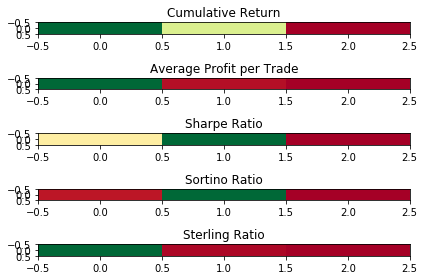

In [36]:
titles = ["Cumulative Return", "Average Profit per Trade",
          "Sharpe Ratio", "Sortino Ratio", "Sterling Ratio"]
df = [[cumulativeBH, cumulativeMOM, cumulativeMR],
      [averageBH, averageMOM, averageMR],
      [sharpeBH, sharpeMOM, sharpeMR],
      [sortinoBH, sortinoMOM, sortinoMR],
      [sterlingBH, sterlingMOM, sterlingMR]]

base = len(df) * 100 + 1 * 10 + 1

print("     Buy and Hold\tMomentum\tMean Reversion")
for metric, title in zip(df, titles):
    plt.subplot(base)
    plt.title(title)
    plt.imshow([metric], cmap = "RdYlGn", aspect = "auto")
    base += 1

plt.tight_layout()